In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')


In [25]:
def estimate_purity_completness(df_obj, tru_obj, match_value = 1):
    """Estimate the purity and completness of the detected objects
    
        Parameters
    ----------
    obj4_field : `pd.dataframe`
        Detected objects
    tru_obj : `pd.dataframe`
        True variable objects
    match_value : `float`
        matching radius in arcsec    
    
    Returns
    -------
    purity, completeness  : `float`, `float`
        Purity and completness
    """

    # all of the diaObjects in a field
    dia_obj_SC = SkyCoord(ra=df_obj['ra'].values*u.degree, dec=df_obj['dec'].values*u.degree) 
    # all of the variable objects in a field
    tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
    # match the observations to the truth
    idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
    # index of all diaObj that are within match_value of a true variable object
    idx_close = idx[d2d.to(u.arcsec).value<match_value]

    # all of diaObjects thare are within match_value of a variable object
    matches_close = df_obj.iloc[idx_close]

    # fraction of dia Objects that are actually near a variable objects 
    purity = len(matches_close)/len(df_obj)

    # fraction of variable objects that have been detected 
    completnes = len(matches_close)/len(tru_obj_SC)

    return purity, completnes

In [26]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

In [27]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'


# none of these are needed anymore 

#collections = 'u/elhoward/DM-44138/LSSTComCamSim'
#schema =  f'elhoward_dm44138_LSSTComCamSim'

#butler = dafButler.Butler(repo, instrument=instrument)
#registry = butler.registry
#skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
#apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

In [28]:
# We do not use Cassandra anymore

# from lsst.analysis.ap import apdbCassandra
# or4_apdb_Cassandra = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcamsim_or4.py')

In [29]:
# 3
# postgresql://usdf-prompt-processing.slac.stanford.edu/lsst-devl
# Namespace pp_apdb_lsstcomcamsim

# 4
# postgresql://usdf-prompt-processing.slac.stanford.edu/lsst-devl
# Namespace pp_apdb_lsstcomcamsim_or4

repo = 'embargo_or4'

instrument = 'LSSTComCamSim'
schema =  f'pp_ppdb_lsstcomcamsim_or4'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

In [30]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())
    
list_of_diaSource_columns = df_columns['column_name'].tolist()

list_of_flags = [s for s in list_of_diaSource_columns if 'flag' in s or 'Flag' in s]
list_of_flags

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

['centroid_flag',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trail_flag_edge',
 'forced_PsfFlux_flag',
 'forced_PsfFlux_flag_edge',
 'forced_PsfFlux_flag_noGoodPixels',
 'shape_flag',
 'shape_flag_no_pixels',
 'shape_flag_not_contained',
 'shape_flag_parent_source',
 'pixelFlags',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_offimage',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'pixelFlags_streak',
 'pixelFlags_streakCenter',
 'pixelFlags_injected',
 'pixelFlags_injectedCenter',
 'pixelFlags_injected_template',
 'pixelFlags_injected_templateCenter']

In [31]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())
    
list_of_diaSource_columns = df_columns['column_name'].tolist()

list_of_flags = [s for s in list_of_diaSource_columns if 'flag' in s or 'Flag' in s]
list_of_flags

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

['centroid_flag',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trail_flag_edge',
 'forced_PsfFlux_flag',
 'forced_PsfFlux_flag_edge',
 'forced_PsfFlux_flag_noGoodPixels',
 'shape_flag',
 'shape_flag_no_pixels',
 'shape_flag_not_contained',
 'shape_flag_parent_source',
 'pixelFlags',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_offimage',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'pixelFlags_streak',
 'pixelFlags_streakCenter',
 'pixelFlags_injected',
 'pixelFlags_injectedCenter',
 'pixelFlags_injected_template',
 'pixelFlags_injected_templateCenter']

In [32]:
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'pp_ppdb_lsstcomcamsim_or4' AND table_name = 'DiaForcedSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())
    
list_of_diaForcedSource_columns = df_columns['column_name'].tolist()

Available columns: ['diaForcedSourceId', 'diaObjectId', 'ra', 'dec', 'visit', 'detector', 'psfFlux', 'psfFluxErr', 'midpointMjdTai', 'scienceFlux', 'scienceFluxErr', 'band', 'time_processed', 'time_withdrawn']


In [33]:
or4_obj = apdbQuery.load_objects(limit=1e7)

# We got all of them, less than 1e7 here
assert len(or4_obj) < 1e7

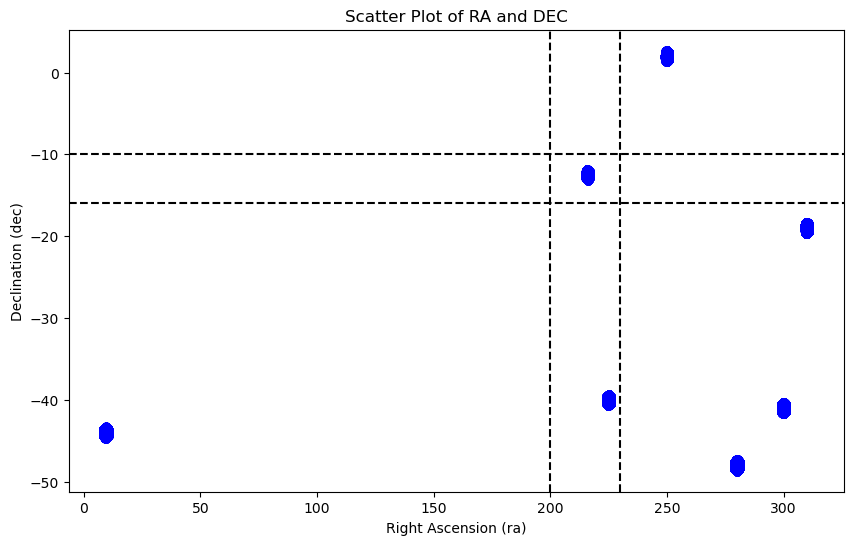

In [34]:
# Extract the columns 'ra' and 'dec'
ra = or4_obj['ra']
dec = or4_obj['dec']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ra, dec, c='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Right Ascension (ra)')
plt.ylabel('Declination (dec)')
plt.title('Scatter Plot of RA and DEC')

plt.axhline(y=-10, color='k', ls = '--')
plt.axhline(y=-16, color='k', ls = '--')
plt.axvline(x=200, color='k', ls = '--')
plt.axvline(x=230, color='k', ls = '--')

# Show the plot
plt.show()

In [35]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > 200) & (or4_obj['ra'] < 230) & (or4_obj['dec'] > -16) & (or4_obj['dec'] < -10)]
obj4_field



,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
153062,3068394109505896449,2024-06-26 02:12:25+00:00,None,215.940635,1.164427e-05,-12.980294,1.620619e-05,4.259947e-11,60487.089310,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
153063,3068394109505896450,2024-06-26 02:49:53+00:00,None,215.932781,NaN,-12.977373,NaN,NaN,60487.115497,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:48:25+00:00,6
153064,3068394109505896451,2024-06-26 02:49:53+00:00,None,215.955608,NaN,-12.984331,NaN,NaN,60487.115497,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:58+00:00,3
153065,3068394109505896452,2024-06-26 02:32:51+00:00,None,216.003270,9.587428e-07,-12.998648,9.911652e-07,3.736781e-15,60487.103777,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:58+00:00,3
153066,3068394109505896453,2024-06-26 02:12:25+00:00,None,215.952055,1.678011e-05,-12.981463,1.948738e-05,2.935007e-11,60487.089310,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171479,3068394172890218585,2024-06-26 02:55:53+00:00,None,215.677023,2.335178e-05,-12.260069,2.930849e-05,-1.390424e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171480,3068394172890218592,2024-06-26 02:55:53+00:00,None,215.558428,NaN,-12.258833,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171481,3068394172890218629,2024-06-26 02:55:53+00:00,None,215.749328,NaN,-12.203916,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171482,3068394172890218631,2024-06-26 02:55:53+00:00,None,215.565520,3.946260e-05,-12.211074,4.004168e-05,-9.789058e-13,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1


In [36]:
# no flags are avaliable anymore in the object list
print(list(obj4_field.columns))

['diaObjectId', 'validityStart', 'validityEnd', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'radecMjdTai', 'pmRa', 'pmRaErr', 'pmDec', 'pmDecErr', 'parallax', 'parallaxErr', 'pmRa_pmDec_Cov', 'pmRa_parallax_Cov', 'pmDec_parallax_Cov', 'pmParallaxLnL', 'pmParallaxChi2', 'pmParallaxNdata', 'u_psfFluxMean', 'u_psfFluxMeanErr', 'u_psfFluxSigma', 'u_psfFluxChi2', 'u_psfFluxNdata', 'u_fpFluxMean', 'u_fpFluxMeanErr', 'u_fpFluxSigma', 'g_psfFluxMean', 'g_psfFluxMeanErr', 'g_psfFluxSigma', 'g_psfFluxChi2', 'g_psfFluxNdata', 'g_fpFluxMean', 'g_fpFluxMeanErr', 'g_fpFluxSigma', 'r_psfFluxMean', 'r_psfFluxMeanErr', 'r_psfFluxSigma', 'r_psfFluxChi2', 'r_psfFluxNdata', 'r_fpFluxMean', 'r_fpFluxMeanErr', 'r_fpFluxSigma', 'i_psfFluxMean', 'i_psfFluxMeanErr', 'i_psfFluxSigma', 'i_psfFluxChi2', 'i_psfFluxNdata', 'i_fpFluxMean', 'i_fpFluxMeanErr', 'i_fpFluxSigma', 'z_psfFluxMean', 'z_psfFluxMeanErr', 'z_psfFluxSigma', 'z_psfFluxChi2', 'z_psfFluxNdata', 'z_fpFluxMean', 'z_fpFluxMeanErr', 'z_fpFluxSigma',

In [37]:
ra_min = obj4_field['ra'].min()-0.01
ra_max = obj4_field['ra'].max()+0.01
dec_min = obj4_field['dec'].min()-0.01
dec_max = obj4_field['dec'].max()+0.01

In [38]:
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "time_processed", 
            "time_withdrawn",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [39]:
list_of_diaForcedSource_columns

['diaForcedSourceId',
 'diaObjectId',
 'ra',
 'dec',
 'visit',
 'detector',
 'psfFlux',
 'psfFluxErr',
 'midpointMjdTai',
 'scienceFlux',
 'scienceFluxErr',
 'band',
 'time_processed',
 'time_withdrawn']

In [40]:
with apdbQuery.connection as connection:
    srcForced4_field = pd.read_sql_query(f'''
        SELECT 
            "diaForcedSourceId", 
            "diaObjectId", 
            "ra", 
            "dec",
            "visit",
            "detector", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "band"
        FROM "{schema}"."DiaForcedSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [41]:
print(len(srcForced4_field))
print(len(src4_field))


0
75818


In [42]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long 
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')
#df_single_gal = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i)+'.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

obj4_field  = obj4_field[
    (obj4_field['ra'] >= ra_min) & (obj4_field['ra'] <= ra_max) &
    (obj4_field['dec'] >= dec_min) & (obj4_field['dec'] <= dec_max)]


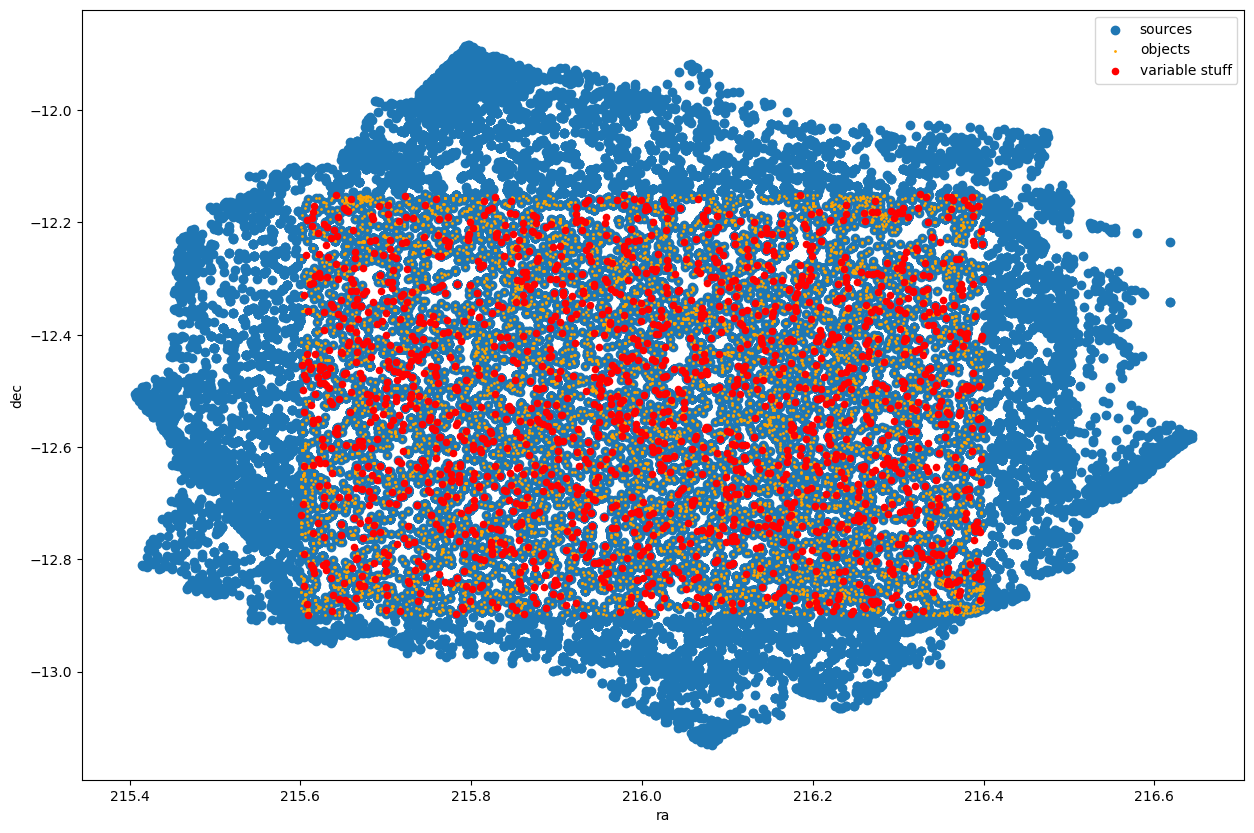

In [43]:
plt.figure(figsize=(15,10))

plt.scatter(src4_field['ra'],src4_field['dec'], label = 'sources')
plt.scatter(obj4_field['ra'],obj4_field['dec'], s=1, color = 'orange', label = 'objects')
plt.scatter(tru_var_obj['ra'],tru_var_obj['dec'], color = 'red', label = 'variable stuff', s=20)
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

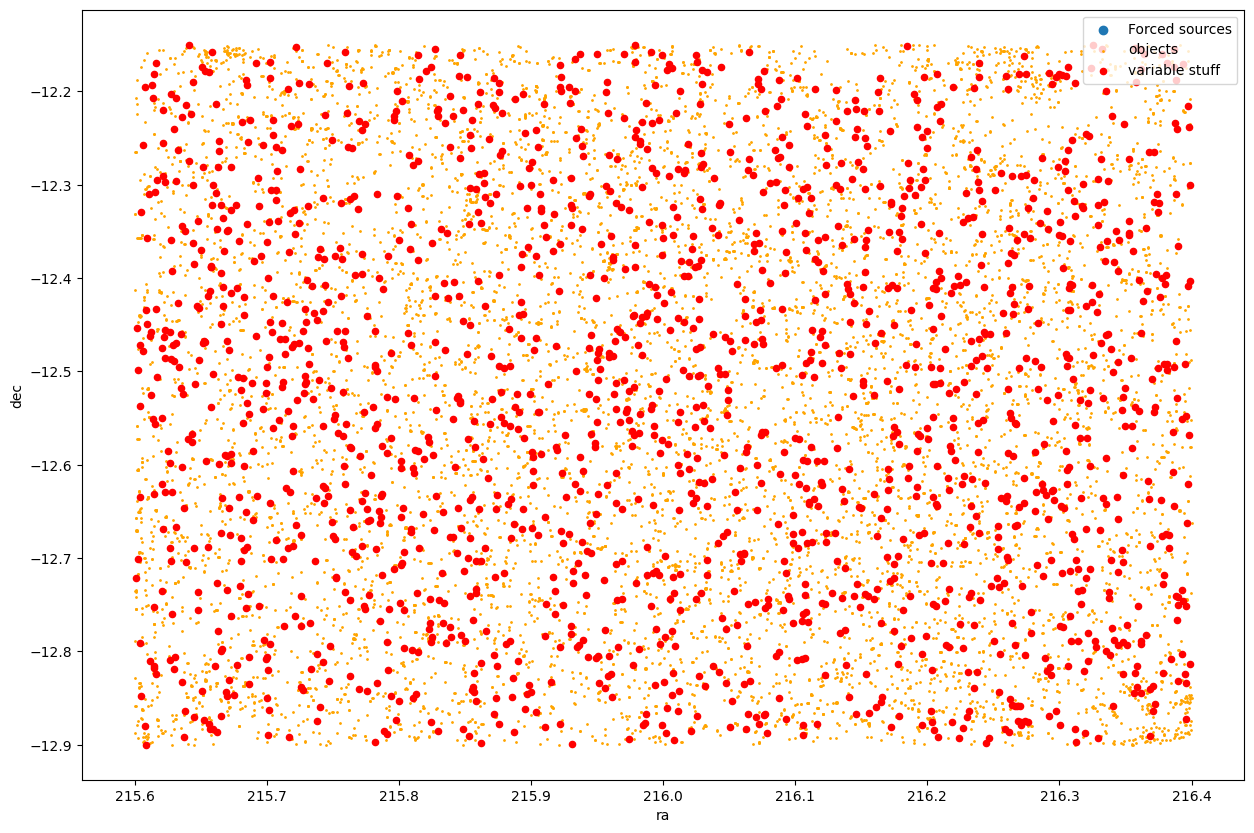

In [44]:
plt.figure(figsize=(15,10))

plt.scatter(srcForced4_field['ra'],srcForced4_field['dec'], label = 'Forced sources')
plt.scatter(obj4_field['ra'],obj4_field['dec'], s=1, color = 'orange', label = 'objects')
plt.scatter(tru_var_obj['ra'],tru_var_obj['dec'], color = 'red', label = 'variable stuff', s=20)
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

# What flags should we use to clean up the dataset

In [45]:
# remove all objects for which any source has any flag
filtered_src4_field= src4_field[~src4_field[list_of_flags].any(axis=1)]
obj4_field_super_clean = obj4_field[obj4_field['diaObjectId'].isin(filtered_src4_field['diaObjectId'])]

In [46]:
len(obj4_field)

9942

In [47]:
len(obj4_field_super_clean)

4894

Text(0.5, 0, 'Number of sources per object')

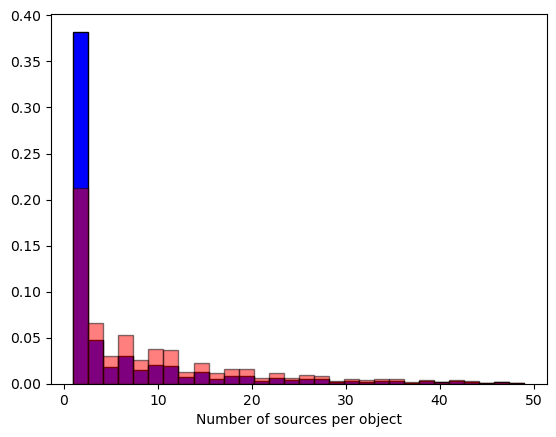

In [48]:
# histogram of the number of sources per objects, the ones that cleaned and not
plt.hist(obj4_field['nDiaSources'], bins=30, density=True, color='blue', edgecolor='black');
plt.hist(obj4_field_super_clean['nDiaSources'], bins=30, density=True, color='red', edgecolor='black', alpha=0.5);
plt.xlabel('Number of sources per object')


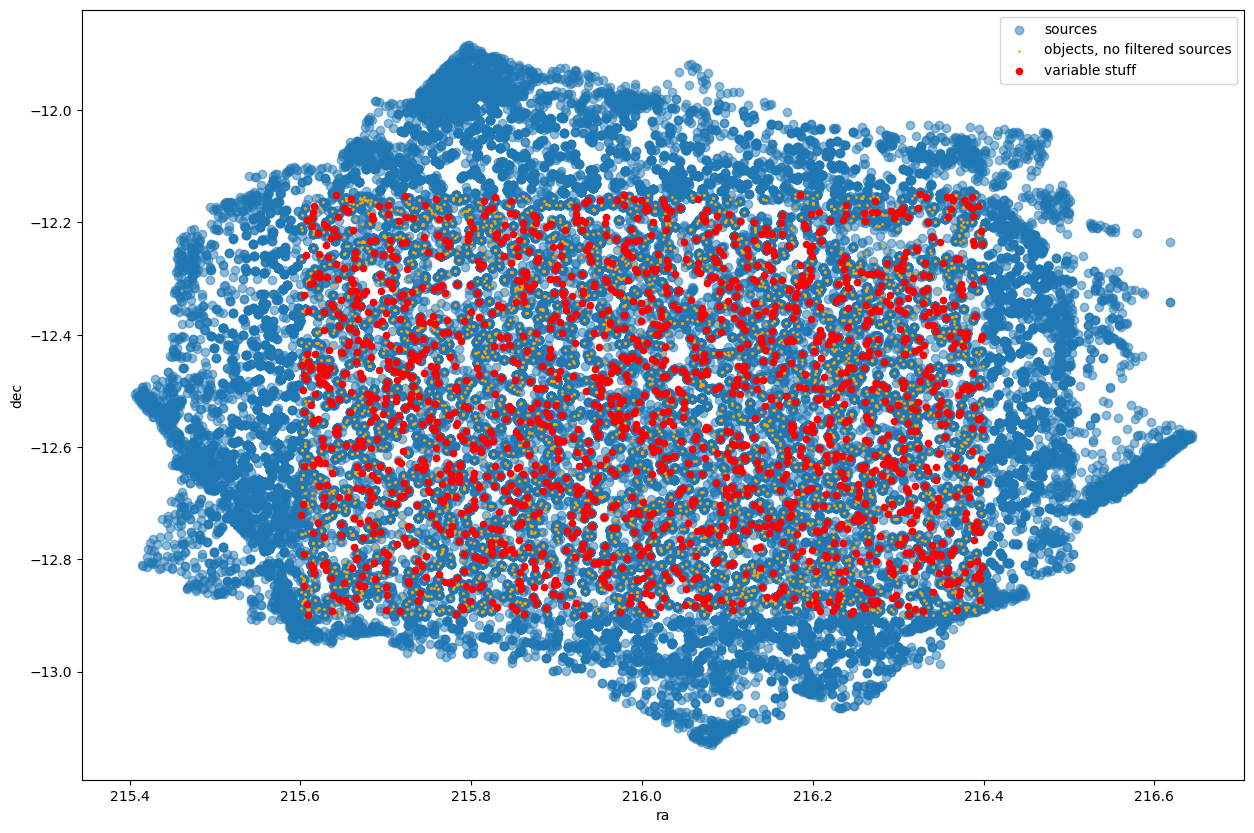

In [49]:
# show the subselection we made 

plt.figure(figsize=(15,10))

plt.scatter(src4_field['ra'],src4_field['dec'], label = 'sources', alpha=0.5)
plt.scatter(obj4_field_super_clean['ra'],obj4_field_super_clean['dec'], s=1, color = 'orange', label = 'objects, no filtered sources')
plt.scatter(tru_var_obj['ra'],tru_var_obj['dec'], color = 'red', label = 'variable stuff', s=20)
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

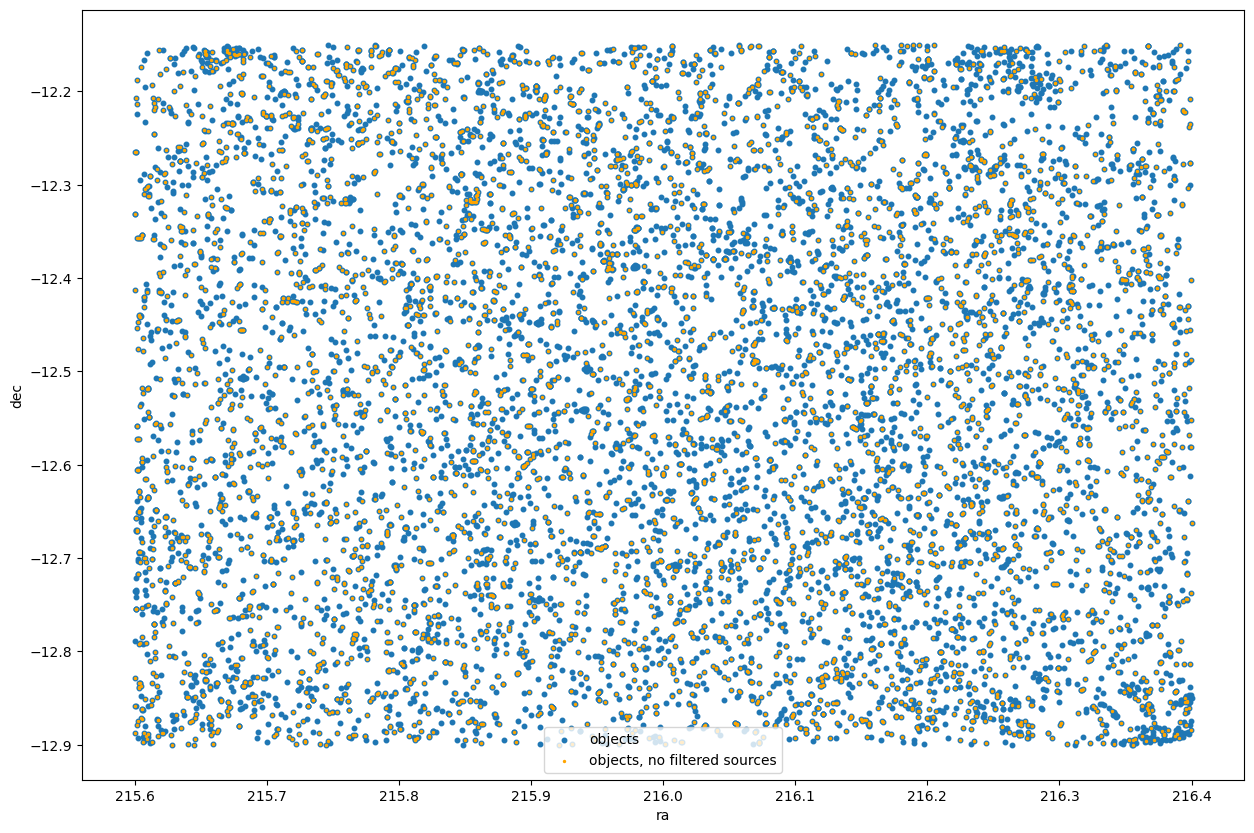

In [50]:
plt.figure(figsize=(15,10))

plt.scatter(obj4_field['ra'],obj4_field['dec'], label = 'objects', s=10.5)
plt.scatter(obj4_field_super_clean['ra'],obj4_field_super_clean['dec'], s=2, color = 'orange', label = 'objects, no filtered sources')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend()

In [51]:
list_of_flags

['centroid_flag',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trail_flag_edge',
 'forced_PsfFlux_flag',
 'forced_PsfFlux_flag_edge',
 'forced_PsfFlux_flag_noGoodPixels',
 'shape_flag',
 'shape_flag_no_pixels',
 'shape_flag_not_contained',
 'shape_flag_parent_source',
 'pixelFlags',
 'pixelFlags_bad',
 'pixelFlags_cr',
 'pixelFlags_crCenter',
 'pixelFlags_edge',
 'pixelFlags_interpolated',
 'pixelFlags_interpolatedCenter',
 'pixelFlags_offimage',
 'pixelFlags_saturated',
 'pixelFlags_saturatedCenter',
 'pixelFlags_suspect',
 'pixelFlags_suspectCenter',
 'pixelFlags_streak',
 'pixelFlags_streakCenter',
 'pixelFlags_injected',
 'pixelFlags_injectedCenter',
 'pixelFlags_injected_template',
 'pixelFlags_injected_templateCenter']

In [52]:
# lets look at this one, as difImg limit is around 23.5
tru_var_obj_bright = tru_var_obj[tru_var_obj['magnorm'] < 23.5]
tru_var_obj_bright

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,variability_model,salt2_params,is_variable,period,mag_amplitude,phase
2423,star,1072180941,216.191984,-12.209090,0,21.491287,starSED/kurucz/km25_6000.fits_g30_6080.gz,3.1,0.273828,-2.670000,-1.510000,85.809998,0.050910,,None,True,6.915724,0.124658,3.876700
2424,star,250325369,216.162784,-12.201172,0,20.740699,starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...,3.1,0.272701,-11.440000,-3.780000,6.960000,1.020000,,None,True,8.165801,0.879210,1.432904
2437,star,774753087,216.171834,-12.242497,0,20.432092,starSED/kurucz/km10_5250.fits_g15_5410.gz,3.1,0.273828,-0.250000,-5.520000,-2.620000,0.155239,,None,True,8.323236,0.613939,4.452022
2471,star,774752488,216.145104,-12.209442,0,19.986461,starSED/phoSimMLT/lte039-6.0-0.5a+0.2.BT-Settl...,3.1,0.271574,-16.469999,-26.530001,44.380001,1.079444,,None,True,0.395981,0.955521,0.744393
2485,star,774748554,216.134804,-12.276501,0,19.132947,starSED/kurucz/km15_5750.fits_g25_5990.gz,3.1,0.272701,-5.080000,-5.760000,28.049999,0.149348,,None,True,0.669193,0.607598,2.928880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172065,star,584556672,216.336481,-12.295612,0,22.160624,starSED/phoSimMLT/lte033-4.5-1.0a+0.4.BT-Settl...,3.1,0.285096,-17.639999,-12.180000,-87.580002,1.155580,,None,True,2.727213,0.849070,3.424665
172074,star,774767576,216.367692,-12.264789,0,23.013089,starSED/phoSimMLT/lte034-4.5-1.0a+0.4.BT-Settl...,3.1,0.285096,5.930000,-11.930000,49.790001,0.658264,,None,True,5.587030,0.344152,3.104635
172095,star,1072185411,216.331309,-12.272234,0,19.068648,starSED/kurucz/km20_6250.fits_g30_6270.gz,3.1,0.285096,-3.910000,-1.630000,297.429990,0.084411,,None,True,0.182028,0.656478,2.028350
174237,star,1072184172,216.377521,-12.399553,0,22.384865,starSED/kurucz/km15_5000.fits_g05_5060.gz,3.1,0.282842,-0.750000,-5.180000,-110.080000,0.098628,,None,True,0.161654,0.105586,1.369566


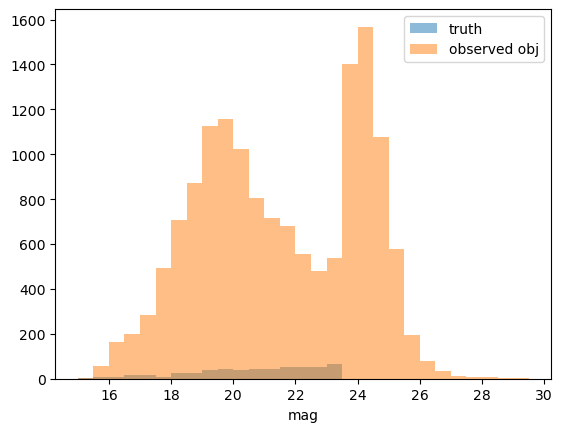

In [53]:
src4_field_mag, src4_field_magerr = create_mag_errors(src4_field['scienceFlux'], src4_field['scienceFluxErr'])
src4_field['science_mag'] = src4_field_mag

df_grouped = src4_field.groupby('diaObjectId').agg({
    'science_mag': 'mean',
    'diaSourceId': 'count'  # Optional: if you want to know the number of sources per object
}).reset_index()

# If you only need the 'diaObjectId' and mean 'scienceFlux', you can drop 'diaSourceId'
df_grouped = df_grouped[['diaObjectId', 'science_mag']]

plt.hist(tru_var_obj_bright['magnorm'],bins=np.arange(15, 30, 0.5), alpha=0.5, label='truth')
plt.hist(df_grouped['science_mag'],bins=np.arange(15, 30, 0.5), alpha=0.5, label='observed obj')

plt.xlabel('mag')
plt.legend()

In [54]:
obj4_field_merged = pd.merge(obj4_field, df_grouped[['diaObjectId', 'science_mag']], on='diaObjectId', how='left')
obj4_field_bright = obj4_field_merged[obj4_field_merged['science_mag'] < 23.5]


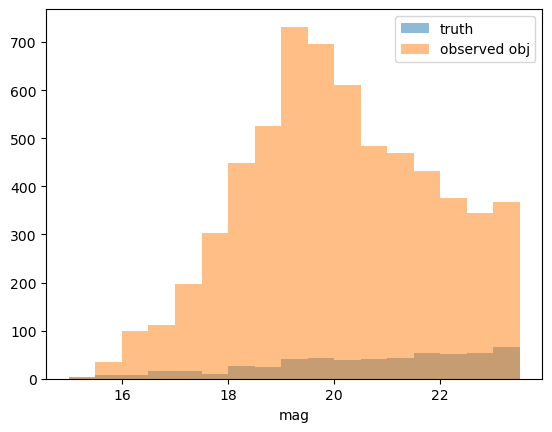

In [55]:
plt.hist(tru_var_obj_bright['magnorm'],bins=np.arange(15, 24, 0.5), alpha=0.5, label='truth')
plt.hist(obj4_field_bright['science_mag'],bins=np.arange(15, 24, 0.5), alpha=0.5, label='observed obj')

plt.xlabel('mag')
plt.legend()

In [56]:
# unit tests 

# if comparing to itself, should be 1 for both completness and purity
print(estimate_purity_completness(tru_var_obj, tru_var_obj))

# if taking only half of the true objects, should be 0.5 completness and 1 for purity
print(estimate_purity_completness(tru_var_obj[0:int(len(tru_var_obj)/2)], tru_var_obj))

# if offseting the ra so that half are out of match, it should be 0.5 for both
tru_var_obj_test = tru_var_obj.copy(deep=False)
tru_var_obj_test['ra'] = tru_var_obj_test['ra'] + np.random.uniform(0, 2/3600, len(tru_var_obj_test))
print(estimate_purity_completness(tru_var_obj_test, tru_var_obj))

(1.0, 1.0)
(1.0, 0.49971799210377893)
(0.526790750141004, 0.526790750141004)


In [57]:
tru_var_obj

,object_type,id,ra,dec,host_galaxy_id,magnorm,sed_filepath,MW_rv,MW_av,mura,mudec,radial_velocity,parallax,variability_model,salt2_params,is_variable,period,mag_amplitude,phase
3,star,1009994123,216.207569,-12.180939,0,24.234124,starSED/kurucz/km15_4500.fits_g00_4680.gz,3.1,0.274954,-0.34,-2.50,38.580002,0.060423,,None,True,0.991257,0.103657,3.916524
2419,star,1072181022,216.190249,-12.202527,0,26.385021,starSED/kurucz/km30_4250.fits_g00_4330.gz,3.1,0.273828,-1.50,-2.19,208.200000,0.038548,,None,True,2.133275,0.620653,3.572403
2423,star,1072180941,216.191984,-12.209090,0,21.491287,starSED/kurucz/km25_6000.fits_g30_6080.gz,3.1,0.273828,-2.67,-1.51,85.809998,0.050910,,None,True,6.915724,0.124658,3.876700
2424,star,250325369,216.162784,-12.201172,0,20.740699,starSED/phoSimMLT/lte037-5.5-1.0a+0.4.BT-Settl...,3.1,0.272701,-11.44,-3.78,6.960000,1.020000,,None,True,8.165801,0.879210,1.432904
2437,star,774753087,216.171834,-12.242497,0,20.432092,starSED/kurucz/km10_5250.fits_g15_5410.gz,3.1,0.273828,-0.25,-5.52,-2.620000,0.155239,,None,True,8.323236,0.613939,4.452022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174234,star,930634037,216.379745,-12.405843,0,24.057310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-0.48,-7.38,8.530000,0.851922,,None,True,0.140427,0.427471,5.435825
174237,star,1072184172,216.377521,-12.399553,0,22.384865,starSED/kurucz/km15_5000.fits_g05_5060.gz,3.1,0.282842,-0.75,-5.18,-110.080000,0.098628,,None,True,0.161654,0.105586,1.369566
174238,star,774762453,216.380578,-12.396774,0,22.344290,starSED/kurucz/km30_4000.fits_g05_4200.gz,3.1,0.282842,-1.46,-1.73,-24.010000,0.240215,,None,True,6.917946,0.675635,3.769819
174265,star,774761880,216.372721,-12.395497,0,26.200310,starSED/phoSimMLT/lte032-4.5-1.0a+0.4.BT-Settl...,3.1,0.282842,-8.97,-1.31,-1.410000,0.329155,,None,True,0.390458,0.790919,4.527125


In [58]:
len(obj4_field)

9942

In [59]:
# no cleaning
print(estimate_purity_completness(obj4_field_bright, tru_var_obj_bright))

# Create a new DataFrame with random 'ra' and 'dec' values
df_random = pd.DataFrame({
    'ra': np.random.uniform(ra_min, ra_max, len(obj4_field_bright)),
    'dec': np.random.uniform(dec_min, dec_max, len(obj4_field_bright))
})

print(estimate_purity_completness(df_random, tru_var_obj_bright))

(0.08164902149502727, 0.9121863799283154)
(0.0003208213025344883, 0.0035842293906810036)


In [60]:
# remove all objects for which any source has any flag
filtered_src4_field= src4_field[~src4_field[list_of_flags].any(axis=1)]
obj4_field_super_clean = obj4_field_bright[obj4_field_bright['diaObjectId'].isin(filtered_src4_field['diaObjectId'])]

# without objects for which any source has any flags
estimate_purity_completness(obj4_field_super_clean, tru_var_obj_bright)

(0.07700394218134034, 0.525089605734767)

In [61]:
# more than 10 observations in any band
obj4_field_more_obs = obj4_field_bright[obj4_field_bright['nDiaSources']>10]
estimate_purity_completness(obj4_field_more_obs, tru_var_obj_bright)

(0.2472934472934473, 0.7777777777777778)

In [62]:
band_counts = src4_field.groupby(['diaObjectId', 'band']).size().unstack(fill_value=0)
# Rename the columns in band_counts
band_counts_renamed = band_counts.rename(columns={
    'g': 'nDiaSources_g',
    'r': 'nDiaSources_r',
    'i': 'nDiaSources_i'
})
# Merge obj4_field with band_counts on diaObjectId
obj4_field_with_band_counts = pd.merge(obj4_field_bright, band_counts_renamed, on='diaObjectId', how='left')

# If needed, fill NaN values with 0 (in case some diaObjectId in obj4_field doesn't exist in band_counts)
obj4_field_with_band_counts = obj4_field_with_band_counts.fillna(0)

In [63]:
# at least one observation in each band
obj4_field_at_least_1_in_band = obj4_field_with_band_counts[(obj4_field_with_band_counts['nDiaSources_g']>1) & (obj4_field_with_band_counts['nDiaSources_r']>1) & (obj4_field_with_band_counts['nDiaSources_i']>1)]
estimate_purity_completness(obj4_field_at_least_1_in_band, tru_var_obj_bright)

(0.24293405114401076, 0.6469534050179212)

In [64]:
# a bit more systematic - testing each flag separately

list_of_pur_comp_as_function_of_flags = []
for i in range(len(list_of_flags)):
    # remove all objects for which any source has one flag
    filtered_src4_field= src4_field[~src4_field[[list_of_flags[i]]].any(axis=1)]
    obj4_field_one_flag_cleaned = obj4_field_bright[obj4_field_bright['diaObjectId'].isin(filtered_src4_field['diaObjectId'])]
    list_of_pur_comp_as_function_of_flags.append(estimate_purity_completness(obj4_field_one_flag_cleaned, tru_var_obj_bright))

arr_of_pur_comp_as_function_of_flags = np.array(list_of_pur_comp_as_function_of_flags)

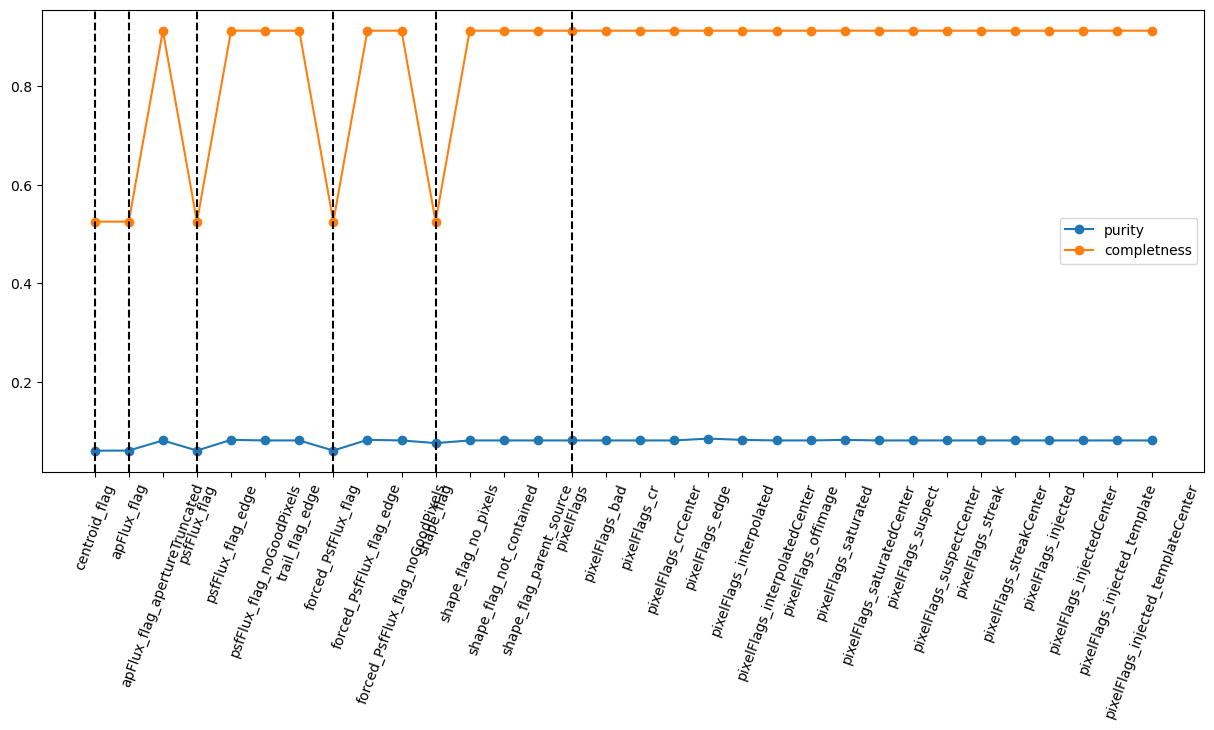

In [65]:
plt.figure(figsize=(15,6)) 
plt.plot(arr_of_pur_comp_as_function_of_flags[:,0], label='purity', marker='o')
plt.plot(arr_of_pur_comp_as_function_of_flags[:,1], label='completness', marker='o')
plt.axvline(x=0, color='k', ls = '--')
plt.axvline(x=1, color='k', ls = '--')
plt.axvline(x=3, color='k', ls = '--')
plt.axvline(x=7, color='k', ls = '--')
plt.axvline(x=10, color='k', ls = '--')
plt.axvline(x=14, color='k', ls = '--')

plt.legend()
plt.xticks(range(len(list_of_flags)), list_of_flags, rotation=70);

In [66]:
src4_field.columns


Index(['diaSourceId', 'diaObjectId', 'ra', 'dec', 'midpointMjdTai', 'psfFlux',
       'psfFluxErr', 'scienceFlux', 'scienceFluxErr', 'snr', 'band',
       'time_processed', 'time_withdrawn', 'centroid_flag', 'apFlux_flag',
       'apFlux_flag_apertureTruncated', 'psfFlux_flag', 'psfFlux_flag_edge',
       'psfFlux_flag_noGoodPixels', 'trail_flag_edge', 'forced_PsfFlux_flag',
       'forced_PsfFlux_flag_edge', 'forced_PsfFlux_flag_noGoodPixels',
       'shape_flag', 'shape_flag_no_pixels', 'shape_flag_not_contained',
       'shape_flag_parent_source', 'pixelFlags', 'pixelFlags_bad',
       'pixelFlags_cr', 'pixelFlags_crCenter', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_interpolatedCenter',
       'pixelFlags_offimage', 'pixelFlags_saturated',
       'pixelFlags_saturatedCenter', 'pixelFlags_suspect',
       'pixelFlags_suspectCenter', 'pixelFlags_streak',
       'pixelFlags_streakCenter', 'pixelFlags_injected',
       'pixelFlags_injectedCenter', 'pixelFlags_inje

(0.0, 1.0)

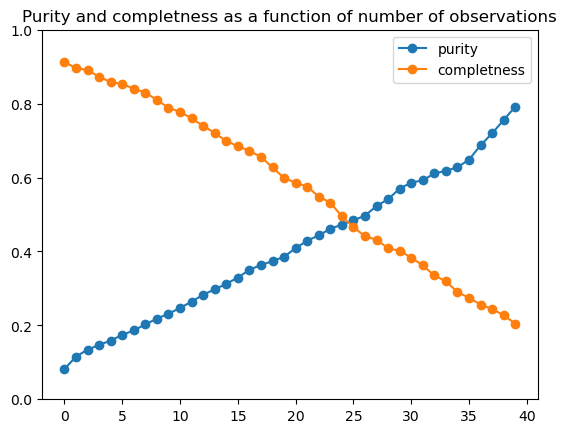

In [67]:
list_of_pur_comp_as_function_of_nobs = []
for i in range(40):
    # more than 10 observations in any band
    obj4_field_more_obs = obj4_field_bright[obj4_field_bright['nDiaSources']>i]
    list_of_pur_comp_as_function_of_nobs.append(estimate_purity_completness(obj4_field_more_obs, tru_var_obj_bright))
    
arr_of_pur_comp_as_function_of_nobs = np.array(list_of_pur_comp_as_function_of_nobs)

plt.plot(arr_of_pur_comp_as_function_of_nobs[:,0], label='purity', marker='o')
plt.plot(arr_of_pur_comp_as_function_of_nobs[:,1], label='completness', marker='o')
plt.legend()
plt.title('Purity and completness as a function of number of observations')
plt.ylim(0,1)

Text(0.5, 1.0, 'Purity and completness as a function of snr')

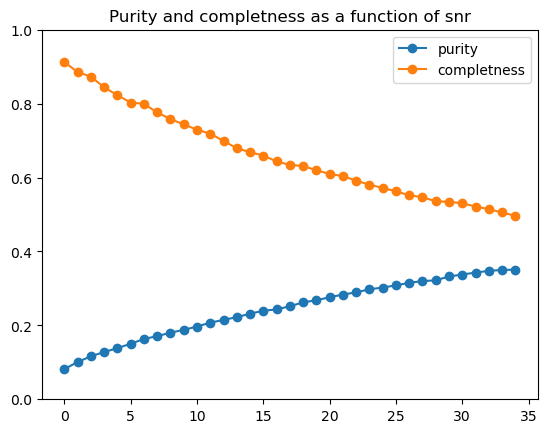

In [68]:
list_of_pur_comp_as_function_of_snr = []
for i in range(5,40):
    # more than 10 observations in any band
    obj4_field_filtered = obj4_field_bright[obj4_field_bright['diaObjectId'].isin(src4_field[src4_field['snr'] > i]['diaObjectId'].unique())]
    list_of_pur_comp_as_function_of_snr.append(estimate_purity_completness(obj4_field_filtered, tru_var_obj_bright))
    
list_of_pur_comp_as_function_of_snr = np.array(list_of_pur_comp_as_function_of_snr)

arr_of_pur_comp_as_function_of_snr = np.array(list_of_pur_comp_as_function_of_snr)

plt.plot(arr_of_pur_comp_as_function_of_snr[:,0], label='purity', marker='o')
plt.plot(arr_of_pur_comp_as_function_of_snr[:,1], label='completness', marker='o')
plt.ylim(0,1)
plt.legend()
plt.title('Purity and completness as a function of snr')



In [69]:
# it would be useful to have diffimLimitingMagnitude
# total number of obs possible at this point

# Compare number of objects in postgres and Cassandra

In [70]:
# compare number of sources

# Get column names for the DiaSource table
column_names = or4_apdb_Cassandra._apdb._schema.apdbColumnNames(ApdbTables.DiaSource)

# Build the query for the specified ra and dec range
query = or4_apdb_Cassandra._build_query(
    ApdbTables.DiaSource,
    columns=column_names,
    where='ra >= 200 AND ra <= 230 AND dec >= -16 AND dec <= -10',
    limit=100000  # Adjust the limit as needed, or remove for no limit
)

# Prepare and execute the query
statement = or4_apdb_Cassandra._apdb._preparer.prepare(query)
result = or4_apdb_Cassandra._apdb._session.execute(
    statement,
    timeout=200,
    execution_profile="read_pandas"
)

# Convert the result to a pandas DataFrame
src4_field_Cassandra = cast(pd.DataFrame, result._current_rows)

NameError: name 'or4_apdb_Cassandra' is not defined

In [ ]:
with apdbQuery.connection as connection:
    src4_field_postgress = pd.read_sql_query(f'SELECT "diaSourceId", "diaObjectId", "ra", "dec", "midpointMjdTai", \
                                 "psfFlux", "psfFluxErr", \
                                 "scienceFlux", "scienceFluxErr", "snr", \
                                 "band", "time_processed", "time_withdrawn"  \
                                 FROM "{schema}"."DiaSource" \
                                 WHERE "ra" BETWEEN 200 AND 230 \
                                 AND "dec" BETWEEN -16 AND -10 \
                                 LIMIT 3000000; ''', connection)

In [ ]:
len(src4_field_Cassandra)

75818

In [ ]:
print('Len src4_field_Cassandra filter is %i' % len(src4_field_Cassandra))
print('Len src4_field_postgress filter is %i' % len(src4_field_postgress))

Len src4_field_Cassandra filter is 75818
Len src4_field_postgress filter is 75818


In [ ]:
# We got all of them, less than 1e7 here
len(or4_obj)

1429486

In [ ]:
len(or4_obj_Cassandra) - len(or4_obj)

NameError: name 'or4_obj_Cassandra' is not defined

In [ ]:
or4_obj_Cassandra = or4_apdb_Cassandra.load_objects(limit=1e7)

In [ ]:
# Assuming df1 and df2 are your DataFrames

# Merge the two DataFrames and add an indicator column
merged_df = pd.merge(or4_obj, or4_obj_Cassandra, on='diaObjectId', how='outer', indicator=True)

# Filter for rows that are only in df1
only_in_or4_obj = merged_df[merged_df['_merge'] == 'left_only']

# Filter for rows that are only in df2
only_in_or4_Cassandra = merged_df[merged_df['_merge'] == 'right_only']

In [ ]:
only_in_or4_Cassandra

,diaObjectId,validityStart,validityEnd,ra_x,raErr_x,dec_x,decErr_x,ra_dec_Cov_x,radecMjdTai_x,pmRa_x,...,pmRa_y,pmRaErr_y,pmDec_y,pmDecErr_y,parallax_y,parallaxErr_y,pmRa_pmDec_Cov_y,pmRa_parallax_Cov_y,pmDec_parallax_Cov_y,_merge
1430360,3068429478574161958,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only
1430361,3068429478574161965,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only
1430362,3068429478574162017,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only
1430363,3068429478574162025,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only
1430364,3068429478574162053,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only
1430365,3068429478574162075,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only
1430366,3068429478574162103,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only
1430367,3068429478574162131,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,right_only


In [ ]:
or4_obj[(or4_obj['ra'] <10) & (or4_obj['dec'] < -43) & (or4_obj['dec'] > -45)]

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
477889,3068394735497379841,2024-06-26 09:44:07+00:00,None,9.079303,NaN,-43.725441,NaN,NaN,60487.403684,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
477890,3068394735497379842,2024-06-28 10:45:07+00:00,None,9.001821,NaN,-43.764837,NaN,NaN,60489.445085,None,...,None,None,None,None,None,None,None,None,2024-06-28 10:44:41+00:00,80
477891,3068394735497379843,2024-06-28 10:10:34+00:00,None,9.106615,0.000028,-43.720907,0.000026,5.279746e-10,60489.420845,None,...,None,None,None,None,None,None,None,None,2024-06-28 06:50:18+00:00,43
477892,3068394735497379844,2024-06-28 10:45:07+00:00,None,8.997977,0.000020,-43.775473,0.000026,4.352637e-11,60489.445085,None,...,None,None,None,None,None,None,None,None,2024-06-28 10:44:41+00:00,52
477893,3068394735497379845,2024-06-28 10:46:17+00:00,None,9.106524,0.000007,-43.729731,0.000010,-7.629779e-12,60489.445085,None,...,None,None,None,None,None,None,None,None,2024-06-28 10:43:13+00:00,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429479,3068465104275112397,2024-06-28 10:47:59+00:00,None,9.921431,0.000034,-44.460833,0.000027,2.762494e-10,60489.446020,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
1429481,3068465104275112400,2024-06-28 10:47:59+00:00,None,9.804673,NaN,-44.480826,NaN,NaN,60489.446020,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
1429483,3068465104275112403,2024-06-28 10:47:59+00:00,None,9.968769,NaN,-44.453174,NaN,NaN,60489.446020,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
1429484,3068465104275112404,2024-06-28 10:47:59+00:00,None,9.778307,NaN,-44.485894,NaN,NaN,60489.446020,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1


In [ ]:
or4_obj_Cassandra[(or4_obj_Cassandra['ra'] <10) & (or4_obj_Cassandra['dec'] < -43)& (or4_obj_Cassandra['dec'] > -45)]

,diaObjectId,lastNonForcedSource,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,pmRaErr,pmDec,pmDecErr,parallax,parallaxErr,pmRa_pmDec_Cov,pmRa_parallax_Cov,pmDec_parallax_Cov
857544,3068394735497379841,2024-06-26 09:44:07,9.079303,NaN,-43.725441,NaN,NaN,60487.403684,None,None,None,None,None,None,None,None,None
1369903,3068394735497379842,2024-06-28 10:45:07,9.001821,NaN,-43.764837,NaN,NaN,60489.445085,None,None,None,None,None,None,None,None,None
258977,3068394735497379843,2024-06-28 10:10:34,9.106615,0.000028,-43.720907,0.000026,5.279746e-10,60489.420845,None,None,None,None,None,None,None,None,None
1369904,3068394735497379844,2024-06-28 10:45:07,8.997977,0.000020,-43.775473,0.000026,4.352637e-11,60489.445085,None,None,None,None,None,None,None,None,None
258978,3068394735497379845,2024-06-28 10:46:17,9.106524,0.000007,-43.729731,0.000010,-7.629779e-12,60489.445085,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479366,3068465104275112397,2024-06-28 10:47:59,9.921431,0.000034,-44.460833,0.000027,2.762494e-10,60489.446020,None,None,None,None,None,None,None,None,None
412636,3068465104275112400,2024-06-28 10:47:59,9.804673,NaN,-44.480826,NaN,NaN,60489.446020,None,None,None,None,None,None,None,None,None
479367,3068465104275112403,2024-06-28 10:47:59,9.968769,NaN,-44.453174,NaN,NaN,60489.446020,None,None,None,None,None,None,None,None,None
412637,3068465104275112404,2024-06-28 10:47:59,9.778307,NaN,-44.485894,NaN,NaN,60489.446020,None,None,None,None,None,None,None,None,None


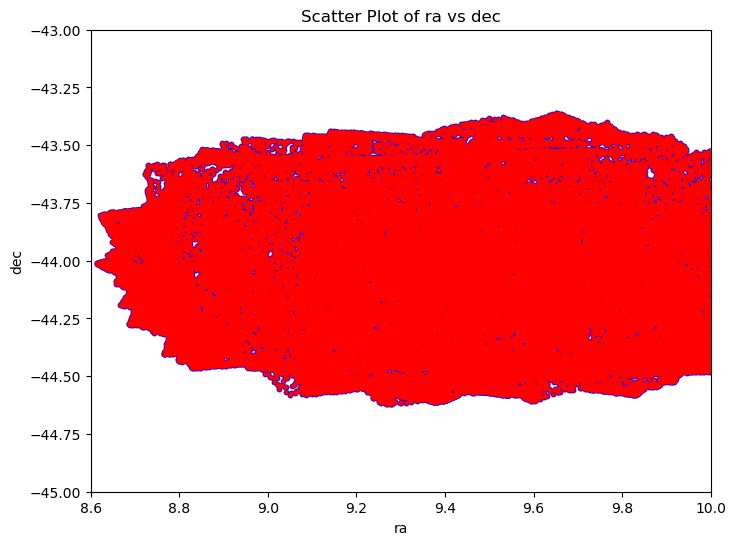

In [ ]:
# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(or4_obj['ra'], or4_obj['dec'], color='blue', marker='o', s=10)
plt.scatter(or4_obj_Cassandra['ra'], or4_obj_Cassandra['dec'], color='red', marker='x', s=5)
# Adding titles and labels
plt.title('Scatter Plot of ra vs dec')
plt.xlabel('ra')
plt.ylabel('dec')

plt.xlim(8.6, 10)
plt.ylim(-45, -43)

# Display the plot
plt.show()


In [ ]:
or4_obj['diaObjectId'].values

array([3068394045081387009, 3068394045081387010, 3068394045081387011, ...,
       3068465104275112403, 3068465104275112404, 3068465104275112405])

In [ ]:
or4_obj_Cassandra['diaObjectId'].values

array([3068394045081387009, 3068394045081387010, 3068394045081387011, ...,
       3068465104275112403, 3068465104275112404, 3068465104275112405])

In [ ]:
# Values in array1 but not in array2
only_in_array1 = np.setdiff1d(or4_obj['ra'].values, or4_obj_Cassandra['ra'].values)

# Values in array2 but not in array1
only_in_array2 = np.setdiff1d( or4_obj_Cassandra['ra'].values, or4_obj['ra'].values)

In [ ]:
len(only_in_array2)

884

In [ ]:
filtered_df = or4_obj_Cassandra[or4_obj_Cassandra['ra'].isin(only_in_array2)]


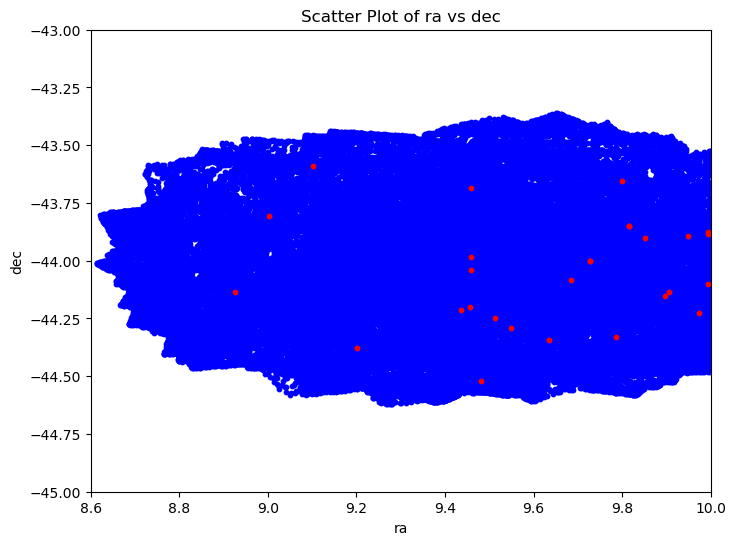

In [ ]:
# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(or4_obj['ra'], or4_obj['dec'], color='blue', marker='o', s=10)
plt.scatter(filtered_df['ra'], filtered_df['dec'], color='red', marker='o', s=10)
# Adding titles and labels
plt.title('Scatter Plot of ra vs dec')
plt.xlabel('ra')
plt.ylabel('dec')

plt.xlim(8.6, 10)
plt.ylim(-45, -43)

# Display the plot
plt.show()



In [ ]:
or4_obj_Cassandra[or4_obj_Cassandra['diaObjectId'] == filtered_df['diaObjectId'].values[0]]

,diaObjectId,lastNonForcedSource,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,pmRaErr,pmDec,pmDecErr,parallax,parallaxErr,pmRa_pmDec_Cov,pmRa_parallax_Cov,pmDec_parallax_Cov
1105210,3068394045081387951,2024-06-28 09:42:25,279.230274,0.000004,-47.908118,0.000006,-2.861271e-12,60489.400636,None,None,None,None,None,None,None,None,None
1152902,3068394045081387951,2024-06-27 05:21:31,279.230279,0.000004,-47.908111,0.000006,-2.861271e-12,60488.217746,None,None,None,None,None,None,None,None,None


In [ ]:
or4_obj[or4_obj['diaObjectId'] == filtered_df['diaObjectId'].values[0]]

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
834,3068394045081387951,2024-06-28 09:42:25+00:00,None,279.230274,0.000004,-47.908118,0.000006,-2.861271e-12,60489.400636,None,...,None,None,None,None,None,None,None,None,2024-06-28 09:29:03+00:00,23
